<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/main/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [3]:
USER = "John"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [4]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [5]:
import tensorflow as tf

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
USE_CROPPED_IMAGES = False
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  BATCH_SIZE = 16
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)
    dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks


train_data, val_data, test_data = DataLoader.load_datasets()


(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)
(450, 450, 3)


## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [ ]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(2**(exp - 1), (3,3), 3, padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(padding="same")(x)
    x = layers.Dropout(0.4)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [ ]:
INPUT_SHAPE = (450,450,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 16)        4624      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 50, 50, 16)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 50, 50, 16)   

In [ ]:
for x in val_data.batch(64).take(1):
  print(x[0].shape)

(64, 450, 450, 3)


In [ ]:
SHOULD_TRAIN = False
save_model_path = os.path.join(PROJECT_FILEPATH, "models", "Base.h5")
if SHOULD_TRAIN:
  cp_filepath = os.path.join(PROJECT_FILEPATH, "models", "Base_Checkpoints")
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, save_best_only=True)
  basic_model.fit(train_data.batch(64), epochs=1000, verbose=1, callbacks=[checkpoint])
  basic_model.save(save_model_path)
else:
  basic_model = tf.keras.models.load_model(save_model_path)


### Analyze Results

In [11]:
# path = os.path.join(PROJECT_FILEPATH, "models", "Base.h5")
# basic_model = tf.keras.models.load_model(path)
images = test_data.map(lambda x,y: x)
predictions = basic_model.predict(images.batch(64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


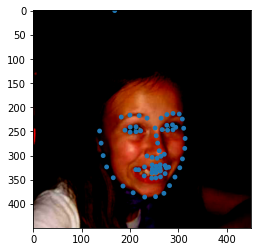

In [16]:
#@title View Predicted Images
image_index = 8 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in images:
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1